# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 38kB/s  eta 0:00:01
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

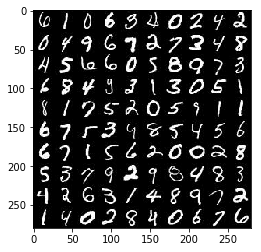

In [2]:
show_n_images = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

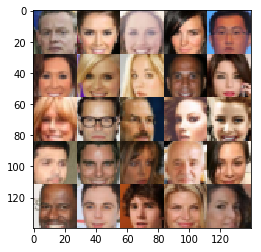

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    real_input_images = tf.placeholder(dtype = tf.float32, shape = [None, image_width, image_height, image_channels], name = 'real_inputs')
    z_input = tf.placeholder(dtype = tf.float32, shape = [None, z_dim], name = 'z_inputs')
    learn_rate = tf.placeholder(dtype = tf.float32, name = 'learning_rate')
    
    return (real_input_images, z_input, learn_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py", line 832, in start\n    self._run_callback(self._callbacks.popleft())', 'File

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        # input 28x28x3
        x = tf.layers.conv2d(images, kernel_size=5, filters=64, strides=2, padding='same')
        x = tf.maximum(alpha * x, x)
        
        # 14x14x64
        x = tf.layers.conv2d(x, kernel_size=5, filters=128, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)
        
        # 7x7x128
        x = tf.layers.conv2d(x, kernel_size=5, filters=256, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)
        
        # 4x4x256
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, units=128)
        x = tf.maximum(alpha * x, x)
        logits = tf.layers.dense(x, units=1)
        out = tf.sigmoid(logits)
        
        return (out, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        alpha = 0.2
        # First fully connected layer
        x = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x = tf.reshape(x, (-1, 7, 7, 512))
        x = tf.layers.batch_normalization(x, training= is_train)
        x = tf.maximum(alpha * x, x)
        # 7x7x512 now
        
        x = tf.layers.conv2d_transpose(x, 256, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training= is_train)
        x = tf.maximum(alpha * x, x)
        # 14x14x256 now
        
        x = tf.layers.conv2d_transpose(x, 128, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training= is_train)
        x = tf.maximum(alpha * x, x)
        # 28x28x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 5, strides=1, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train = True)
    d_model_real, d_logits_real = discriminator(input_real, reuse = False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse = True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * 0.9)) 
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return (d_train_opt, g_train_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [15]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    image_width, image_height, image_channels = data_shape[1], data_shape[2], data_shape[3]
    
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    saver = tf.train.Saver()

    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                #Rescale
                batch_images = batch_images*2 
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images, learn_rate: learning_rate})

                if steps % 100 == 0:
                    # print the losses every 100 steps
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}..., step {}".format(epoch_i+1, epochs, steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)

        saver.save(sess, './checkpoints/generator.ckpt')
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2..., step 100 Discriminator Loss: 2.0230... Generator Loss: 0.2370


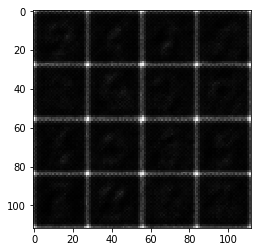

Epoch 1/2..., step 200 Discriminator Loss: 1.0562... Generator Loss: 1.1901


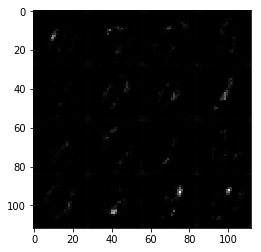

Epoch 1/2..., step 300 Discriminator Loss: 0.9581... Generator Loss: 1.3421


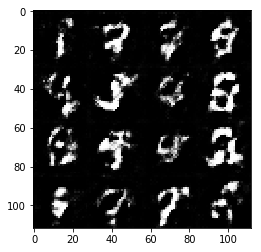

Epoch 1/2..., step 400 Discriminator Loss: 1.0957... Generator Loss: 1.3072


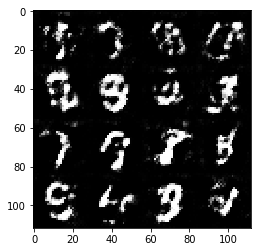

Epoch 1/2..., step 500 Discriminator Loss: 1.0809... Generator Loss: 1.9340


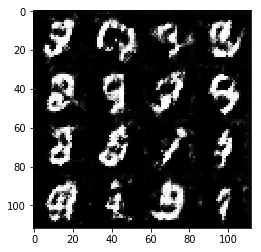

Epoch 1/2..., step 600 Discriminator Loss: 1.0365... Generator Loss: 1.0513


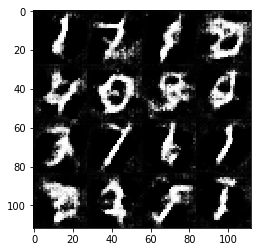

Epoch 1/2..., step 700 Discriminator Loss: 0.9707... Generator Loss: 1.1386


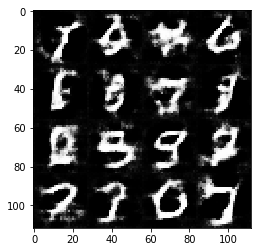

Epoch 1/2..., step 800 Discriminator Loss: 1.4463... Generator Loss: 0.5233


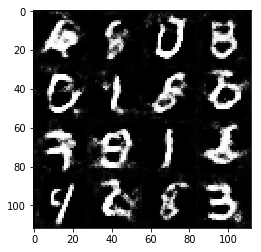

Epoch 1/2..., step 900 Discriminator Loss: 1.1137... Generator Loss: 0.8397


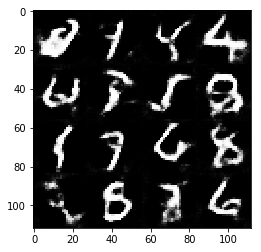

Epoch 1/2..., step 1000 Discriminator Loss: 1.3808... Generator Loss: 0.5591


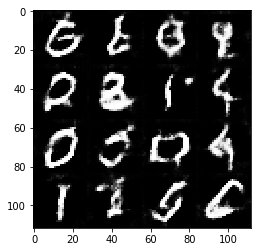

Epoch 1/2..., step 1100 Discriminator Loss: 1.5061... Generator Loss: 0.4701


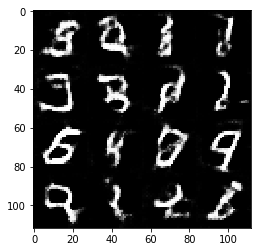

Epoch 1/2..., step 1200 Discriminator Loss: 1.5993... Generator Loss: 0.4321


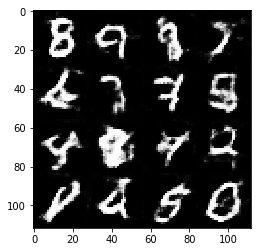

Epoch 1/2..., step 1300 Discriminator Loss: 1.0699... Generator Loss: 0.8512


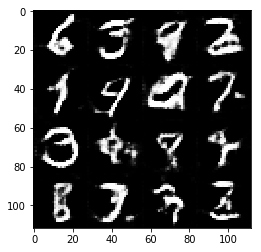

Epoch 1/2..., step 1400 Discriminator Loss: 1.0711... Generator Loss: 0.8908


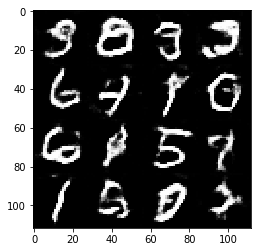

Epoch 1/2..., step 1500 Discriminator Loss: 1.0534... Generator Loss: 0.8320


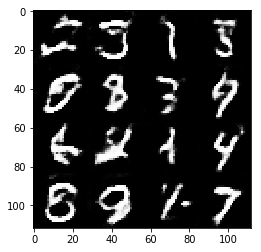

Epoch 1/2..., step 1600 Discriminator Loss: 1.0833... Generator Loss: 0.8743


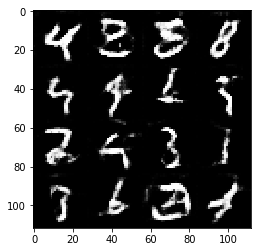

Epoch 1/2..., step 1700 Discriminator Loss: 0.8627... Generator Loss: 1.1894


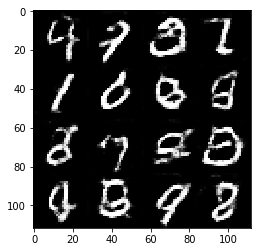

Epoch 1/2..., step 1800 Discriminator Loss: 1.0927... Generator Loss: 2.3362


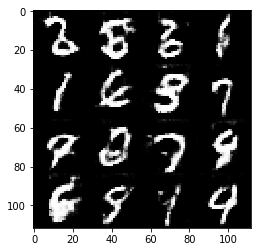

Epoch 2/2..., step 1900 Discriminator Loss: 1.1325... Generator Loss: 0.7774


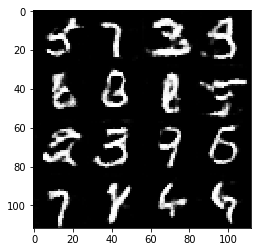

Epoch 2/2..., step 2000 Discriminator Loss: 1.3238... Generator Loss: 2.7585


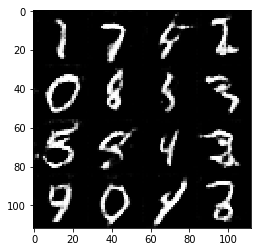

Epoch 2/2..., step 2100 Discriminator Loss: 0.8258... Generator Loss: 1.3682


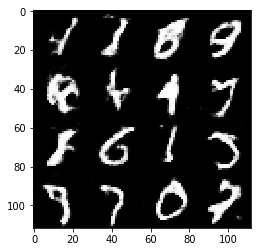

Epoch 2/2..., step 2200 Discriminator Loss: 1.9406... Generator Loss: 0.3842


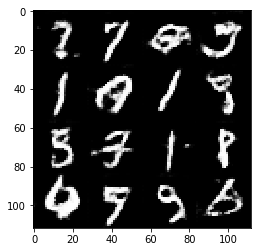

Epoch 2/2..., step 2300 Discriminator Loss: 1.2775... Generator Loss: 0.6343


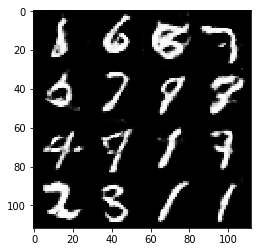

Epoch 2/2..., step 2400 Discriminator Loss: 0.8782... Generator Loss: 1.1876


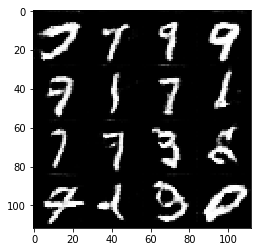

Epoch 2/2..., step 2500 Discriminator Loss: 1.5453... Generator Loss: 0.5416


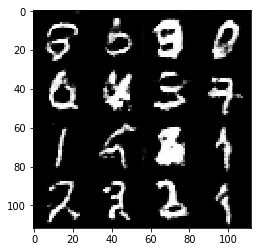

Epoch 2/2..., step 2600 Discriminator Loss: 0.8896... Generator Loss: 1.2042


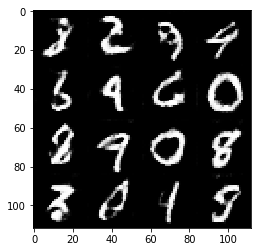

Epoch 2/2..., step 2700 Discriminator Loss: 0.8030... Generator Loss: 1.2677


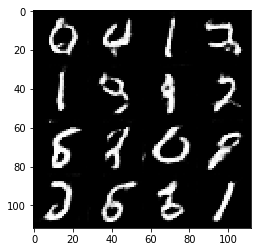

Epoch 2/2..., step 2800 Discriminator Loss: 0.8292... Generator Loss: 1.7128


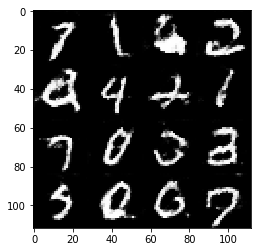

Epoch 2/2..., step 2900 Discriminator Loss: 1.8308... Generator Loss: 0.3988


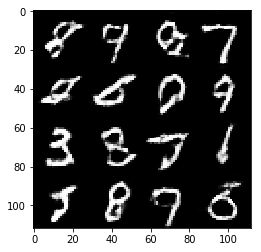

Epoch 2/2..., step 3000 Discriminator Loss: 1.0082... Generator Loss: 0.9895


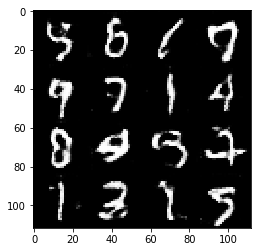

Epoch 2/2..., step 3100 Discriminator Loss: 0.8749... Generator Loss: 1.2399


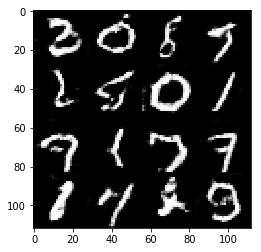

Epoch 2/2..., step 3200 Discriminator Loss: 0.8615... Generator Loss: 1.2062


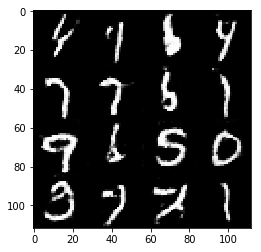

Epoch 2/2..., step 3300 Discriminator Loss: 1.0041... Generator Loss: 0.9296


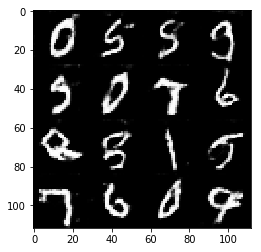

Epoch 2/2..., step 3400 Discriminator Loss: 1.1018... Generator Loss: 0.9048


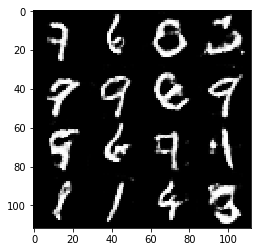

Epoch 2/2..., step 3500 Discriminator Loss: 0.6322... Generator Loss: 1.9320


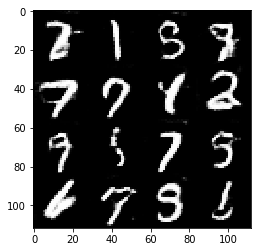

Epoch 2/2..., step 3600 Discriminator Loss: 0.7028... Generator Loss: 1.5528


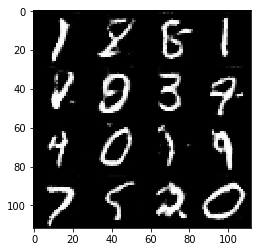

Epoch 2/2..., step 3700 Discriminator Loss: 0.9630... Generator Loss: 0.9987


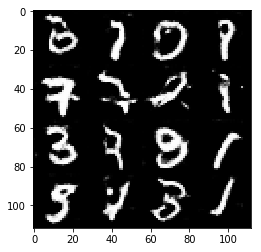

In [16]:
batch_size = 32
z_dim = 128
learning_rate = 0.0001
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1..., step 100 Discriminator Loss: 0.5776... Generator Loss: 2.0946


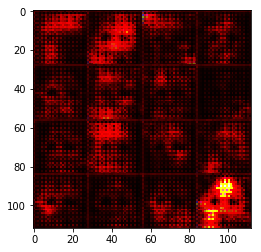

Epoch 1/1..., step 200 Discriminator Loss: 0.3979... Generator Loss: 3.4535


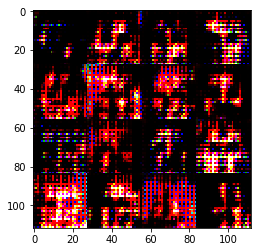

Epoch 1/1..., step 300 Discriminator Loss: 0.3399... Generator Loss: 4.9892


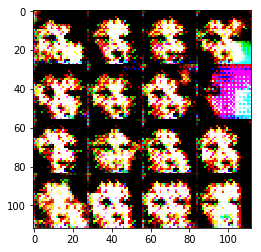

Epoch 1/1..., step 400 Discriminator Loss: 1.3852... Generator Loss: 0.6369


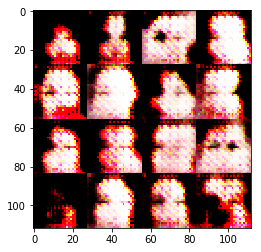

Epoch 1/1..., step 500 Discriminator Loss: 1.1964... Generator Loss: 0.9413


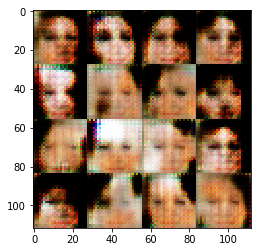

Epoch 1/1..., step 600 Discriminator Loss: 0.9306... Generator Loss: 0.8784


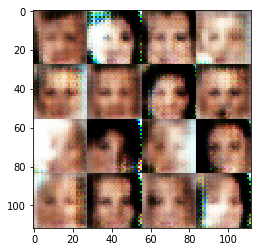

Epoch 1/1..., step 700 Discriminator Loss: 1.5350... Generator Loss: 0.7133


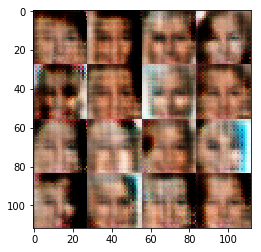

Epoch 1/1..., step 800 Discriminator Loss: 0.8366... Generator Loss: 1.1188


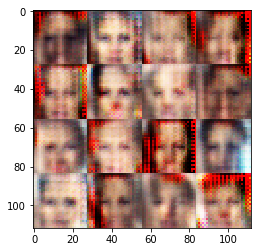

Epoch 1/1..., step 900 Discriminator Loss: 1.3697... Generator Loss: 0.8052


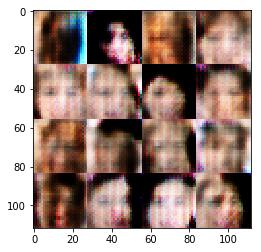

Epoch 1/1..., step 1000 Discriminator Loss: 1.4928... Generator Loss: 0.4253


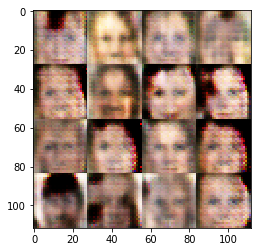

Epoch 1/1..., step 1100 Discriminator Loss: 1.2991... Generator Loss: 0.8445


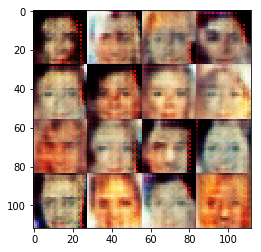

Epoch 1/1..., step 1200 Discriminator Loss: 1.4082... Generator Loss: 1.0865


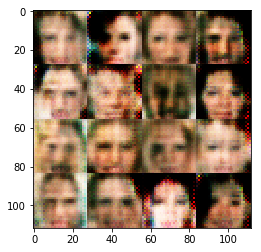

Epoch 1/1..., step 1300 Discriminator Loss: 1.3244... Generator Loss: 1.4372


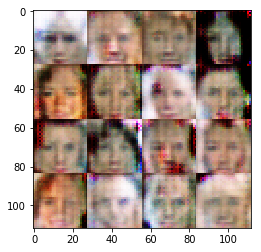

Epoch 1/1..., step 1400 Discriminator Loss: 1.5530... Generator Loss: 0.4035


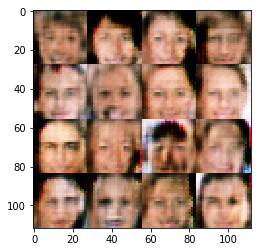

Epoch 1/1..., step 1500 Discriminator Loss: 1.3378... Generator Loss: 0.6943


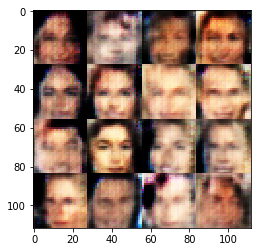

Epoch 1/1..., step 1600 Discriminator Loss: 1.3585... Generator Loss: 0.8896


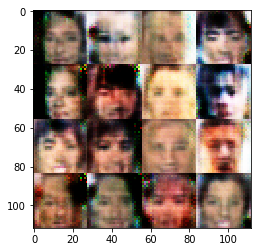

Epoch 1/1..., step 1700 Discriminator Loss: 1.2549... Generator Loss: 1.0235


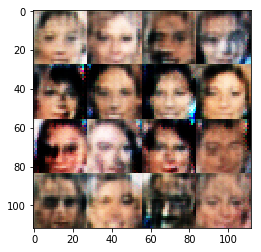

Epoch 1/1..., step 1800 Discriminator Loss: 1.2669... Generator Loss: 0.6948


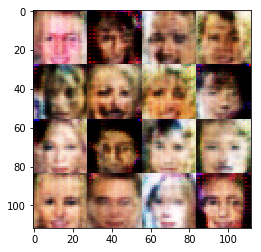

Epoch 1/1..., step 1900 Discriminator Loss: 1.2819... Generator Loss: 0.7787


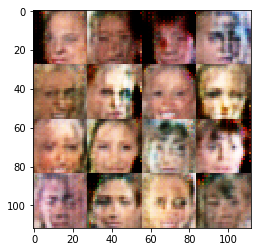

Epoch 1/1..., step 2000 Discriminator Loss: 1.4726... Generator Loss: 0.5594


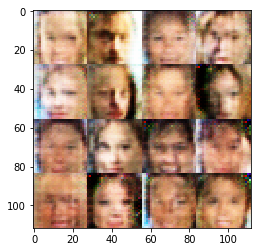

Epoch 1/1..., step 2100 Discriminator Loss: 1.5536... Generator Loss: 0.5689


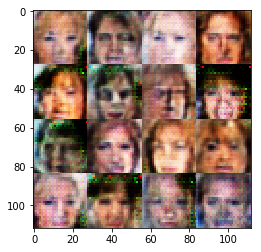

Epoch 1/1..., step 2200 Discriminator Loss: 1.3597... Generator Loss: 0.9815


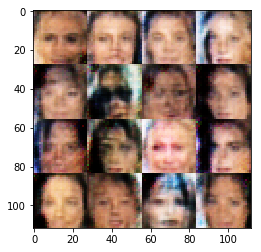

Epoch 1/1..., step 2300 Discriminator Loss: 1.3697... Generator Loss: 0.7509


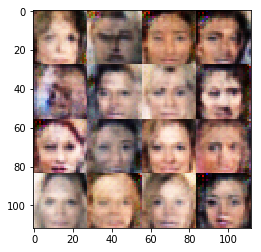

Epoch 1/1..., step 2400 Discriminator Loss: 1.3015... Generator Loss: 0.7538


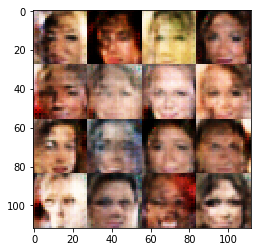

Epoch 1/1..., step 2500 Discriminator Loss: 1.1731... Generator Loss: 0.8493


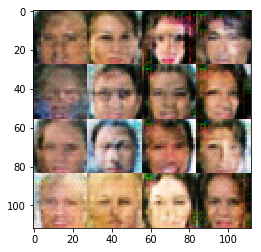

Epoch 1/1..., step 2600 Discriminator Loss: 1.3588... Generator Loss: 0.6486


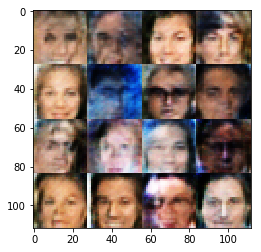

Epoch 1/1..., step 2700 Discriminator Loss: 1.2789... Generator Loss: 0.7564


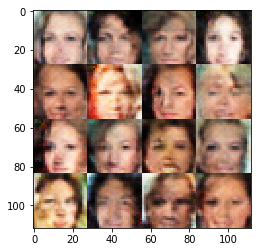

Epoch 1/1..., step 2800 Discriminator Loss: 1.3371... Generator Loss: 0.6855


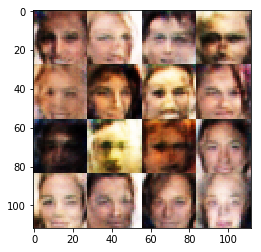

Epoch 1/1..., step 2900 Discriminator Loss: 1.0796... Generator Loss: 0.9283


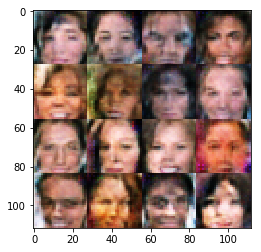

Epoch 1/1..., step 3000 Discriminator Loss: 1.2806... Generator Loss: 0.8591


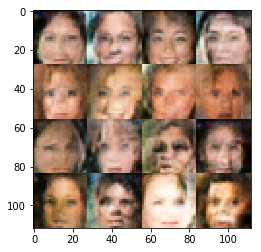

Epoch 1/1..., step 3100 Discriminator Loss: 1.4467... Generator Loss: 1.0757


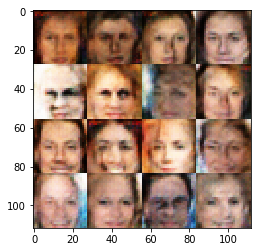

Epoch 1/1..., step 3200 Discriminator Loss: 1.3561... Generator Loss: 0.8521


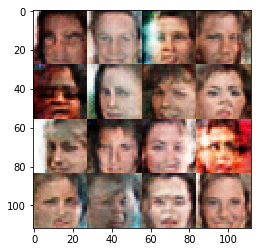

Epoch 1/1..., step 3300 Discriminator Loss: 1.3927... Generator Loss: 0.7094


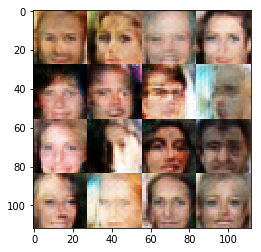

Epoch 1/1..., step 3400 Discriminator Loss: 1.3306... Generator Loss: 0.7885


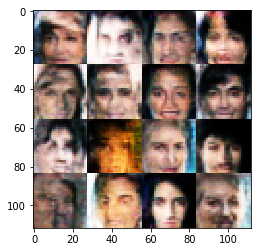

Epoch 1/1..., step 3500 Discriminator Loss: 1.3847... Generator Loss: 0.6311


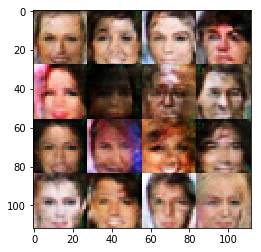

Epoch 1/1..., step 3600 Discriminator Loss: 1.3216... Generator Loss: 0.6964


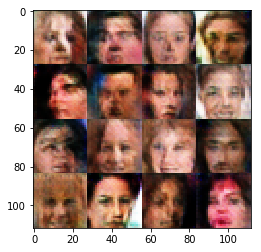

Epoch 1/1..., step 3700 Discriminator Loss: 1.3501... Generator Loss: 0.6436


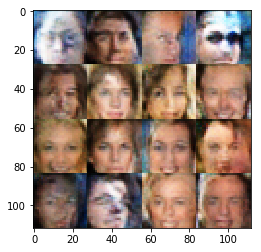

Epoch 1/1..., step 3800 Discriminator Loss: 1.4288... Generator Loss: 0.7256


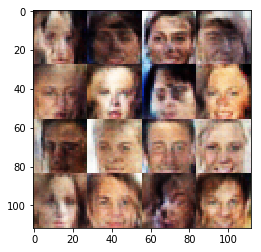

Epoch 1/1..., step 3900 Discriminator Loss: 1.2992... Generator Loss: 0.7567


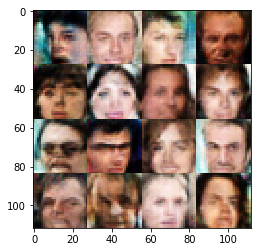

Epoch 1/1..., step 4000 Discriminator Loss: 1.4121... Generator Loss: 0.6897


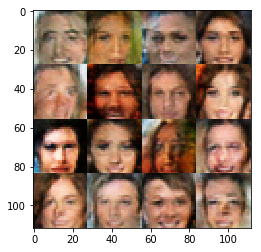

Epoch 1/1..., step 4100 Discriminator Loss: 1.3098... Generator Loss: 0.6221


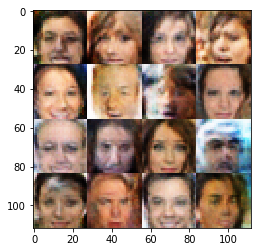

Epoch 1/1..., step 4200 Discriminator Loss: 1.3819... Generator Loss: 0.5900


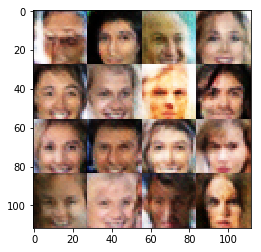

Epoch 1/1..., step 4300 Discriminator Loss: 1.3923... Generator Loss: 0.7193


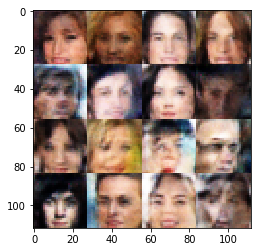

Epoch 1/1..., step 4400 Discriminator Loss: 1.3371... Generator Loss: 0.8073


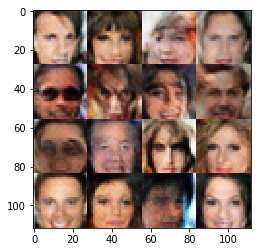

Epoch 1/1..., step 4500 Discriminator Loss: 1.5643... Generator Loss: 0.4796


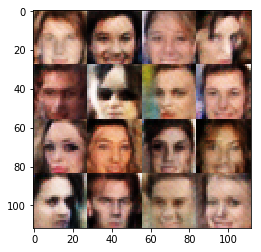

Epoch 1/1..., step 4600 Discriminator Loss: 1.3144... Generator Loss: 0.6760


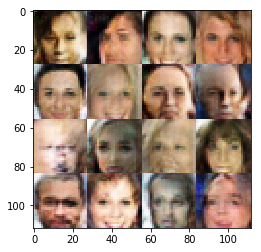

Epoch 1/1..., step 4700 Discriminator Loss: 1.3534... Generator Loss: 0.6908


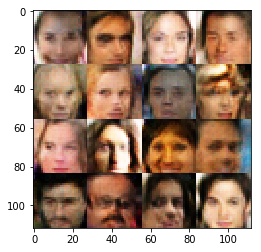

Epoch 1/1..., step 4800 Discriminator Loss: 1.3525... Generator Loss: 0.7766


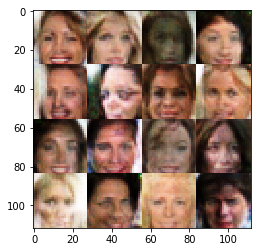

Epoch 1/1..., step 4900 Discriminator Loss: 1.3337... Generator Loss: 0.9637


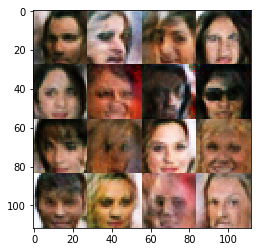

Epoch 1/1..., step 5000 Discriminator Loss: 1.5252... Generator Loss: 0.5942


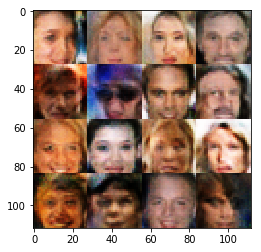

Epoch 1/1..., step 5100 Discriminator Loss: 1.3732... Generator Loss: 0.7653


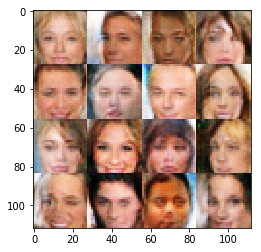

Epoch 1/1..., step 5200 Discriminator Loss: 1.3632... Generator Loss: 0.6735


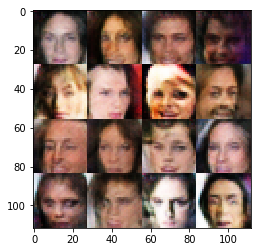

Epoch 1/1..., step 5300 Discriminator Loss: 1.3312... Generator Loss: 0.7849


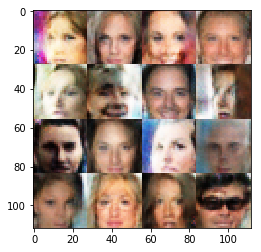

Epoch 1/1..., step 5400 Discriminator Loss: 1.3893... Generator Loss: 0.6891


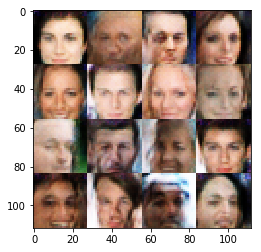

Epoch 1/1..., step 5500 Discriminator Loss: 1.3439... Generator Loss: 0.7073


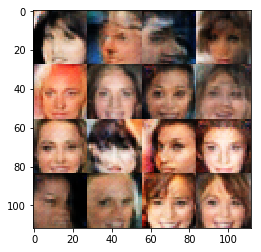

Epoch 1/1..., step 5600 Discriminator Loss: 1.2944... Generator Loss: 0.8179


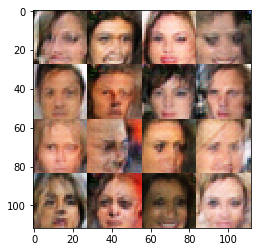

Epoch 1/1..., step 5700 Discriminator Loss: 1.3049... Generator Loss: 0.6933


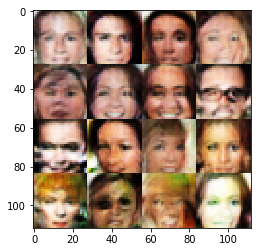

Epoch 1/1..., step 5800 Discriminator Loss: 1.3242... Generator Loss: 0.8501


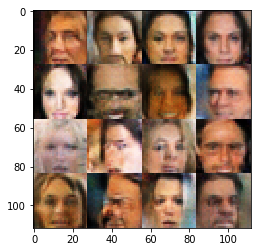

Epoch 1/1..., step 5900 Discriminator Loss: 1.3306... Generator Loss: 0.7822


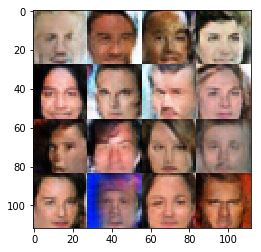

Epoch 1/1..., step 6000 Discriminator Loss: 1.2874... Generator Loss: 0.8570


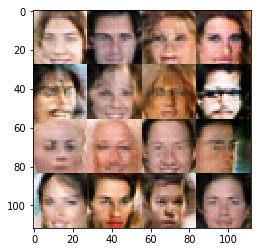

Epoch 1/1..., step 6100 Discriminator Loss: 1.3139... Generator Loss: 0.7785


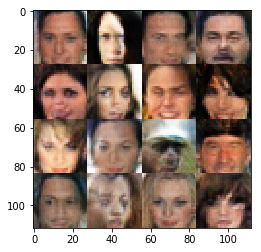

Epoch 1/1..., step 6200 Discriminator Loss: 1.2920... Generator Loss: 0.7528


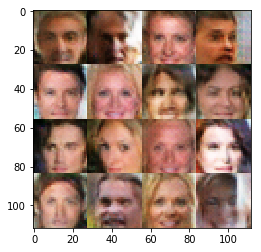

Epoch 1/1..., step 6300 Discriminator Loss: 1.3203... Generator Loss: 0.7700


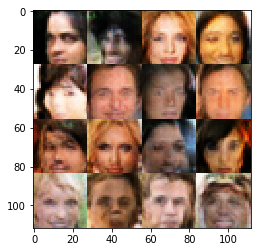

In [18]:
batch_size = 32
z_dim = 128
learning_rate = 0.002
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.